# Batch Gradient Descent Variations
This Notebook provides scratch implementations of various batch gradient descent variations over MNIST Dataset.
Before jumping to tools such as Tensorflow and Theano, getting a gist of how various strategies perform is really
important and this notebook allows the user to run several experiments on a small neural network with one hidden layer.

A simple two layer neural network has been utilised in these implementations.

1. Stochastic Gradient Descent
2. Stochastic Gradient Descent with Momentum

Coming Soon
1. Stochastic Gradient Descent with Nesterov Momentum
2. Accelerated Gradient Descent

In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
from sklearn import preprocessing

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
with open("Datasets\mnist.pkl",'rb') as mnist_file:
    train_data,valid_data,test_data = cPickle.load(mnist_file)

3


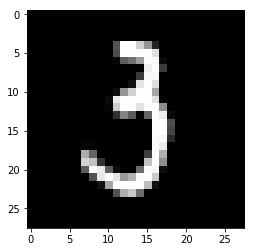

In [3]:
## In this block we are shuffling the data to avoid any classification bias
train_vec_in,train_label_out = train_data
permutation = np.random.permutation(train_vec_in.shape[0])
train_vec_in = train_vec_in[permutation,:]
train_reshape = np.reshape(train_vec_in,newshape=[50000,28,28])
train_label_out = train_label_out[permutation]

plt.imshow(train_reshape[3],cmap='gray')
print train_label_out[3]

In [4]:
valid_features,valid_labels = valid_data
test_features,test_labels = test_data

In [5]:
def confusion_matrix(predicted_outcome,labels):
    classes = set(labels)
    num_classes = len(classes)
    conf_mat = np.zeros((num_classes,num_classes))
    for i in classes:
        for j in classes:
            conf_mat[i,j] = len(np.where((labels == i) & (predicted_outcome == j))[0])
    
    false_positives = np.sum(conf_mat,axis=0)
    false_negatives = np.sum(conf_mat,axis=1)
    precision = np.array([conf_mat[i,i]/false_positives[i] for i in range(10)])
    recall = np.array([conf_mat[i,i]/false_negatives[i] for i in range(10)])
    return precision,recall

In [6]:
def smoothing(x,win_sz=30):
    smoothing_window = np.ones(win_sz)/win_sz
    smooth_func = np.convolve(x,smoothing_window)
    return smooth_func[:-win_sz]

## Two-layer NN with SGD over MNIST

In [7]:
def two_layer_nn_sgd(features,labels,valid_features,valid_labels,hidden_sz=100, \
                     batch_size=200,epoch=10,lamda=0.001,step_size=1,max_iter=100):
    features_dim= np.shape(features)
    classes = set(labels)
    coeff_1 = 0.01 * np.random.randn(features_dim[1],hidden_sz)/(np.sqrt(features_dim[1]))
    coeff_2 = 0.01 * np.random.randn(hidden_sz,len(classes))/(np.sqrt(hidden_sz))

    tot_cost,train_accuracy,valid_accuracy = [],[],[]
    coeff1_dim = np.shape(coeff_1)    
    coeff2_dim = np.shape(coeff_2)
    bias_1 = 0.01 * np.random.randn(1,coeff1_dim[1])
    bias_2 = 0.01 * np.random.randn(1,coeff2_dim[1])

    model = {}

    print 'Training model for batch_size:%d, lamda:%.4f, and step_size: %.4f' % (batch_size,lamda,step_size)
    num_batches = features_dim[0]/batch_size
    
    for _ in xrange(epoch):
        for i in xrange(num_batches):
            batch_features = features[i*batch_size:(i+1)*batch_size]
            batch_dim = np.shape(batch_features)
            batch_labels = labels[i*batch_size:(i+1)*batch_size]
            batch_labels_dim = np.shape(batch_labels)
            
            #### Layer - 1 ####
            reLU = np.maximum(0,np.dot(batch_features,coeff_1) + bias_1)   # reLU - shape (Nxh)

            ## with max-equalization ##
            l2_scores = np.transpose(np.dot(reLU,coeff_2) + bias_2) # [KxN]
            l2_scores_max = np.max(l2_scores,axis=0) # [1xN]
            exp_scores = np.exp(l2_scores-l2_scores_max)
            probs_scores = exp_scores/np.sum(exp_scores,axis=0,keepdims=True)  # probs - shape(KxN)
            
            ## Loss computation
            tot_cost.append(-np.sum(probs_scores[batch_labels,range(batch_dim[0])])/batch_dim[0])
        
            # backpropagation
            probs = np.transpose(probs_scores) # shape - NxK
            probs[range(batch_dim[0]),batch_labels] -= 1
            probs /= batch_dim[0]

            dcoeff_2 = np.dot(reLU.T,probs)   # dcoeff_2 - shape(hxK)
            dbias_2 = np.sum(probs, axis=0, keepdims=True)
            dhidden_layer = np.dot(probs,coeff_2.T)   # dhidden - shape(Nxh)
            dhidden_layer[reLU <= 0] = 0
            dcoeff_1 = np.dot(batch_features.T,dhidden_layer)
            dbias_1 = np.sum(dhidden_layer, axis=0, keepdims=True)

            coeff_2 += -step_size*(dcoeff_2 + lamda*coeff_2)  # coeff_2 - shape(hxK)
            coeff_1 += -step_size*(dcoeff_1 + lamda*coeff_1)  # coeff_1 - shape(Dxh)
            bias_1 += -step_size * dbias_1
            bias_2 += -step_size * dbias_2
            
            ## Runtime Accuracy - Training and Validation 
            hidden_layer_train = np.maximum(0,np.dot(features,coeff_1)+bias_1)
            scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
            predicted_class_train = np.argmax(scores_train, axis=1)
            train_accuracy.append(np.mean(predicted_class_train == labels))
        
            hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
            scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
            predicted_class_valid = np.argmax(scores_valid,axis=1)
            valid_accuracy.append(np.mean(predicted_class_valid == valid_labels))
        
    ##### Training Data accuracy #####
    hidden_layer_train = np.maximum(0,np.dot(features,coeff_1)+bias_1)
    scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
    predicted_class_train = np.argmax(scores_train, axis=1)
    print 'training accuracy: %.4f' % (np.mean(predicted_class_train == labels))
    precision_train,recall_train = confusion_matrix(predicted_class_train,labels)
    print 'training mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_train),np.mean(recall_train))

    ##### Validation Data accuracy #####
    hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
    scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
    predicted_class_valid = np.argmax(scores_valid,axis=1)
    print 'validation accuracy: %.4f' % (np.mean(predicted_class_valid == valid_labels))
    precision_valid,recall_valid = confusion_matrix(predicted_class_valid,valid_labels)
    print 'validation mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_valid),np.mean(recall_valid))   
    
    model['coeffs_l1'] = coeff_1
    model['bias_l1'] = bias_1
    model['coeffs_l2'] = coeff_2
    model['bias_l2'] = bias_2 
    model['train_accuracy'] = train_accuracy
    model['valid_accuracy'] = valid_accuracy
    model['tot_cost'] = tot_cost   
        
    return model

In [8]:
model_sgd = two_layer_nn_sgd(train_vec_in,train_label_out, \
                                                valid_features,valid_labels,batch_size=50, \
                                           epoch=20,hidden_sz=100,lamda=0.0001,step_size=0.75,max_iter=1000)

##### Test Data accuracy #####
hidden_layer_test = np.maximum(0,np.dot(test_features,model_sgd['coeffs_l1'])+model_sgd['bias_l1'])
scores_test = np.dot(hidden_layer_test,model_sgd['coeffs_l2'])+model_sgd['bias_l2']
predicted_class_test = np.argmax(scores_test,axis=1)
print 'test accuracy: %.4f' % (np.mean(predicted_class_test == test_labels))
precision_test,recall_test= confusion_matrix(predicted_class_test,test_labels)
print 'test mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_test),np.mean(recall_test))

Training model for batch_size:50, lamda:0.0001, and step_size: 0.7500
training accuracy: 0.9851
training mean precision: 0.9852, mean recall: 0.9850
validation accuracy: 0.9690
validation mean precision: 0.9692, mean recall: 0.9689
test accuracy: 0.9693
test mean precision: 0.9694, mean recall: 0.9692


### SGD with Momentum

In [9]:
def two_layer_nn_sgd_momentum(features,labels,valid_features,valid_labels,hidden_sz=100, \
                     batch_size=200,epoch=10,lamda=0.001,step_size=1,max_iter=100):
    features_dim= np.shape(features)
    classes = set(labels)
    coeff_1 = 0.01 * np.random.randn(features_dim[1],hidden_sz)/(np.sqrt(features_dim[1]))
    coeff_2 = 0.01 * np.random.randn(hidden_sz,len(classes))/(np.sqrt(hidden_sz))
    
    ## Momentum update parameters
    mu_list = [0.5,0.9,0.95,0.99]
    v_1 = np.zeros((features_dim[1],hidden_sz))
    v_2 = np.zeros((hidden_sz,len(classes)))

    tot_cost,train_accuracy,valid_accuracy = [],[],[]
    coeff1_dim = np.shape(coeff_1)    
    coeff2_dim = np.shape(coeff_2)
    bias_1 = 0.01 * np.random.randn(1,coeff1_dim[1])
    bias_2 = 0.01 * np.random.randn(1,coeff2_dim[1])
    model = {}
    
    print 'Training model for batch_size:%d, lamda:%.4f, and step_size: %.4f' % (batch_size,lamda,step_size)
    num_batches = features_dim[0]/batch_size
    
    for _ in xrange(epoch):
        for i in xrange(num_batches):
            batch_features = features[i*batch_size:(i+1)*batch_size]
            batch_dim = np.shape(batch_features)
            batch_labels = labels[i*batch_size:(i+1)*batch_size]
            batch_labels_dim = np.shape(batch_labels)
            
            #### Layer - 1 ####
            reLU = np.maximum(0,np.dot(batch_features,coeff_1) + bias_1)   # reLU - shape (Nxh)

            ## with max-equalization ##
            l2_scores = np.transpose(np.dot(reLU,coeff_2) + bias_2) # [KxN]
            l2_scores_max = np.max(l2_scores,axis=0) # [1xN]
            exp_scores = np.exp(l2_scores-l2_scores_max)
            probs_scores = exp_scores/np.sum(exp_scores,axis=0,keepdims=True)  # probs - shape(KxN)
            
            ## Loss computation
            tot_cost.append(-np.sum(probs_scores[batch_labels,range(batch_dim[0])])/batch_dim[0])
        
            # backpropagation
            probs = np.transpose(probs_scores) # shape - NxK
            probs[range(batch_dim[0]),batch_labels] -= 1
            probs /= batch_dim[0]

            dcoeff_2 = np.dot(reLU.T,probs)   # dcoeff_2 - shape(hxK)
            dbias_2 = np.sum(probs, axis=0, keepdims=True)
            dhidden_layer = np.dot(probs,coeff_2.T)   # dhidden - shape(Nxh)
            dhidden_layer[reLU <= 0] = 0
            dcoeff_1 = np.dot(batch_features.T,dhidden_layer)
            dbias_1 = np.sum(dhidden_layer, axis=0, keepdims=True)

            v_2 = mu_list[0]*v_2 - (step_size*(dcoeff_2 + lamda*coeff_2))
            coeff_2 += v_2    
            bias_2 += -step_size * dbias_2
            
            v_1 = mu_list[0]*v_1 - (step_size*(dcoeff_1 + lamda*coeff_1))
            coeff_1 += v_1
            bias_1 += -step_size * dbias_1
            
            hidden_layer_train = np.maximum(0,np.dot(features,coeff_1)+bias_1)
            scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
            predicted_class_train = np.argmax(scores_train, axis=1)
            train_accuracy.append(np.mean(predicted_class_train == labels))
        
            hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
            scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
            predicted_class_valid = np.argmax(scores_valid,axis=1)
            valid_accuracy.append(np.mean(predicted_class_valid == valid_labels))
        
    ##### Training Data accuracy #####
    hidden_layer_train = np.maximum(0,np.dot(features,coeff_1)+bias_1)
    scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
    predicted_class_train = np.argmax(scores_train, axis=1)
    print 'training accuracy: %.4f' % (np.mean(predicted_class_train == labels))
    precision_train,recall_train = confusion_matrix(predicted_class_train,labels)
    print 'training mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_train),np.mean(recall_train))

    ##### Validation Data accuracy #####
    hidden_layer_valid = np.maximum(0,np.dot(valid_features,coeff_1)+bias_1)
    scores_valid = np.dot(hidden_layer_valid,coeff_2)+bias_2
    predicted_class_valid = np.argmax(scores_valid,axis=1)
    print 'validation accuracy: %.4f' % (np.mean(predicted_class_valid == valid_labels))
    precision_valid,recall_valid = confusion_matrix(predicted_class_valid,valid_labels)
    print 'validation mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_valid),np.mean(recall_valid))   
    
    model['coeffs_l1'] = coeff_1
    model['bias_l1'] = bias_1
    model['coeffs_l2'] = coeff_2
    model['bias_l2'] = bias_2 
    model['train_accuracy'] = train_accuracy
    model['tot_cost'] = tot_cost    
    
    return model

In [10]:
model_sgd_momentum = two_layer_nn_sgd_momentum(train_vec_in,train_label_out,
                          valid_features,valid_labels,epoch=20,hidden_sz=100,lamda=0.0001,step_size=0.75,max_iter=1000)

##### Test Data accuracy #####
hidden_layer_test = np.maximum(0,np.dot(test_features,model_sgd_momentum['coeffs_l1'])+model_sgd_momentum['bias_l1'])
scores_test = np.dot(hidden_layer_test,model_sgd_momentum['coeffs_l2'])+model_sgd_momentum['bias_l2']
predicted_class_test = np.argmax(scores_test,axis=1)
print 'test accuracy: %.4f' % (np.mean(predicted_class_test == test_labels))
precision_test,recall_test= confusion_matrix(predicted_class_test,test_labels)
print 'test mean precision: %.4f, mean recall: %.4f' % (np.mean(precision_test),np.mean(recall_test))

Training model for batch_size:200, lamda:0.0001, and step_size: 0.7500
training accuracy: 0.9903
training mean precision: 0.9905, mean recall: 0.9901
validation accuracy: 0.9702
validation mean precision: 0.9707, mean recall: 0.9699
test accuracy: 0.9710
test mean precision: 0.9714, mean recall: 0.9707


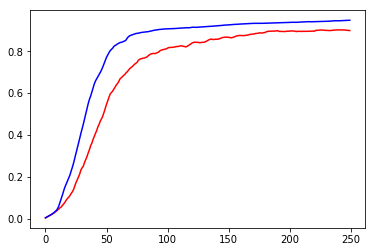

In [15]:
## Plots for Training accuracy for both the models

plt.plot(smoothing(model_sgd['train_accuracy'])[0:250],'r')
plt.plot(smoothing(model_sgd_momentum['train_accuracy'])[0:250],'b')
plt.show()